<a href="https://colab.research.google.com/github/amirhosseinZare23/CIFAR10/blob/main/CIFAR10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import torch
import torchvision
import torchvision.transforms as transforms

In [3]:
import PIL
import random

transforms1 = torchvision.transforms.Compose([
    torchvision.transforms.ColorJitter(hue=.0, saturation=.1),
    torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.RandomRotation([0, 35]),
    torchvision.transforms.RandomSolarize(threshold = 256, p=0.2),
    torchvision.transforms.RandomCrop((32, 32)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

In [4]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 256

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transforms1)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transforms1)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

100%|██████████| 170498071/170498071 [00:13<00:00, 13074152.34it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [5]:
val_ratio = 0.05  # Validation set ratio
dev_ratio = 0.02  # Development set ratio
num_train = len(trainset)
indices = torch.randperm(num_train)  # Generate a random permutation of indices

# Calculate the split indices
val_split = int(val_ratio * num_train)
dev_split = int(dev_ratio * num_train)

# Create separate subsets for training, validation, and development
train_indices = indices[val_split+dev_split:]
val_indices = indices[:val_split]
dev_indices = indices[val_split:val_split+dev_split]

# Create the training, validation, and development data samplers
train_sampler = torch.utils.data.SubsetRandomSampler(train_indices)
val_sampler = torch.utils.data.SubsetRandomSampler(val_indices)
dev_sampler = torch.utils.data.SubsetRandomSampler(dev_indices)

# Create the data loaders for training, validation, and development
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, sampler=train_sampler)
valloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, sampler=val_sampler)
devloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, sampler=dev_sampler)


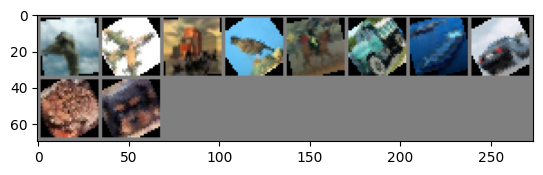

In [6]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images[:10]))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(10)))

In [7]:
import torch.nn as nn
import torch.nn.functional as F


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, 5, padding = 2, device=device)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(32, 128, 5, padding = 2, device=device)
        self.conv3 = nn.Conv2d(128, 256, 5, padding = 2, device=device)
        self.conv4 = nn.Conv2d(256, 512, 5, padding = 2, device=device)
        self.fc1 = nn.Linear(512 * 2 * 2, 120, device=device)
        self.fc2 = nn.Linear(120, 84, device=device)
        self.fc3 = nn.Linear(84, 10, device=device)
        self.dropout = nn.Dropout(p=.3)
        ######################

    def forward(self, x):
       # x = self.to('cuda')
        x = self.pool(F.relu(nn.BatchNorm2d(32, device=device)(self.conv1(x))))
        x = self.pool(F.relu(nn.BatchNorm2d(128, device=device)(self.conv2(x))))
        x = self.pool(F.relu(nn.BatchNorm2d(256, device=device)(self.conv3(x))))
        x = self.pool(F.relu(nn.BatchNorm2d(512, device=device)(self.conv4(x))))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.dropout(F.relu(self.fc2(x)))
        x = self.fc3(x)

        return x


net = Net().to(device)

bird  plane truck bird  horse truck ship  car   frog  dog  


In [8]:
print(device)

cuda:0


In [9]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), betas=(0.9, 0.95), weight_decay=0.005, lr=0.0003)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer = optimizer, step_size = 200, gamma=0.95)

In [10]:
for epoch in range(100):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        #inputs, labels = data
        inputs, labels = data[0].to(device), data[1].to(device)
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        scheduler.step()

        # print statistics
        running_loss += loss.item()
        if i % 100 == 99:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 100:.3f}  Learning Rate: {scheduler.get_lr()[0]}')
            running_loss = 0.0

print('Finished Training')

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:389: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


[1,   100] loss: 1.822  Learning Rate: 0.0003
[2,   100] loss: 1.335  Learning Rate: 0.000285
[3,   100] loss: 1.154  Learning Rate: 0.00027075
[4,   100] loss: 1.045  Learning Rate: 0.0002572125
[5,   100] loss: 0.970  Learning Rate: 0.000244351875
[6,   100] loss: 0.910  Learning Rate: 0.00023213428124999998
[7,   100] loss: 0.874  Learning Rate: 0.00023213428124999998
[8,   100] loss: 0.829  Learning Rate: 0.00022052756718749997
[9,   100] loss: 0.798  Learning Rate: 0.00020950118882812497
[10,   100] loss: 0.767  Learning Rate: 0.00019902612938671872
[11,   100] loss: 0.741  Learning Rate: 0.00018907482291738277
[12,   100] loss: 0.719  Learning Rate: 0.0001796210817715136
[13,   100] loss: 0.695  Learning Rate: 0.00017064002768293793
[14,   100] loss: 0.656  Learning Rate: 0.00016210802629879103
[15,   100] loss: 0.643  Learning Rate: 0.00015400262498385146
[16,   100] loss: 0.629  Learning Rate: 0.00014630249373465888
[17,   100] loss: 0.613  Learning Rate: 0.00013898736904792593

In [11]:
dataiter = iter(testloader)
images, labels = next(dataiter)

# print images
#imshow(torchvision.utils.make_grid(images[:10]))
print('GroundTruth: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(10)))

GroundTruth:  cat   ship  ship  plane frog  frog  car   frog  cat   car  


In [12]:
images = images.to(device)
outputs = net(images)

In [13]:
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join(f'{classes[predicted[j]]:5s}'
                              for j in range(10)))

Predicted:  cat   ship  ship  plane frog  frog  car   frog  cat   car  


In [14]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in devloader:
        images, labels = data
        # calculate outputs by running images through the network
        images = images.to(device)
        labels = labels.to(device)
        outputs = net(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the whole dev images: {100 * correct // total} %')

Accuracy of the network on the whole dev images: 82 %


In [15]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in valloader:
        images, labels = data
        # calculate outputs by running images through the network
        images = images.to(device)
        labels = labels.to(device)
        outputs = net(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the whole val images: {100 * correct // total} %')

Accuracy of the network on the whole val images: 82 %


In [16]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in trainloader:
        images, labels = data
        # calculate outputs by running images through the network
        images = images.to(device)
        labels = labels.to(device)
        outputs = net(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the whole train images: {100 * correct // total} %')

Accuracy of the network on the whole train images: 98 %


In [17]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        images, labels = data
        # calculate outputs by running images through the network
        images = images.to(device)
        labels = labels.to(device)
        outputs = net(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

Accuracy of the network on the 10000 test images: 81 %


In [18]:
# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# again no gradients needed
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images = images.to(device)
        labels = labels.to(device)
        outputs = net(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

Accuracy for class: plane is 84.4 %
Accuracy for class: car   is 92.1 %
Accuracy for class: bird  is 74.3 %
Accuracy for class: cat   is 65.1 %
Accuracy for class: deer  is 78.8 %
Accuracy for class: dog   is 77.0 %
Accuracy for class: frog  is 87.0 %
Accuracy for class: horse is 84.4 %
Accuracy for class: ship  is 88.8 %
Accuracy for class: truck is 86.3 %
